In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import defaultdict
from my_functions import regular_comp

#plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [101]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [102]:
from my_classes import Dummier 

In [103]:
steam_df = pd.read_csv("../data/steam_munged_maydata.csv")

In [116]:
(steam_df["jun_19_av"] >1000).sum()*100/len(steam_df["jun_19_av"])

1.0676680656799942

Exploring target variable:

Target is the uplift in average player numbers between June and July.

It is exponentially distrubuted, so will need some transforming to help with the accuracy of the linear regression:

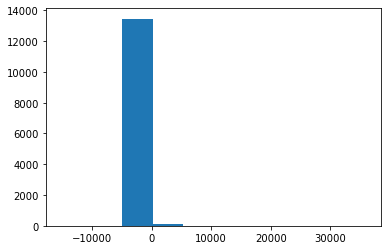

In [79]:
plt.hist(steam_df["jun_jul_avuplift"], bins=10)
plt.show()

But, confirming my inital exploration/hypotheses, more games increase in player numbers than decreased (especially compared to the previous months change (i.e. before the sale). Also that increase was higher among those that were on discount (even if only just...):

In [80]:
# % games that increased player numbers Jun - Jul:
(steam_df["jun_jul_avuplift"]>0).sum()/len(steam_df)

0.5712392312789927

In [81]:
# % games that increased player numbers May - Jun:
(steam_df["may_jun_avuplift"]>0).sum()/len(steam_df)

0.49775421544805243

In [82]:
#% games on discount that increase player numbers:
steam_df.groupby("discount_bin")[["jun_jul_avuplift"]].mean()

,jun_jul_avuplift
discount_bin,
0,3.177358
1,11.423082


In [83]:
#% games on discount that increase player numbers:
steam_df.groupby("discount_bin")[["jun_jul_avuplift"]].median()

,jun_jul_avuplift
discount_bin,
0,0.01
1,0.04


Now let's investigate some outliers:

Firstly from player number uplift:

In [84]:


steam_df[["appid", "name", "price", "jun_jul_avuplift"]].sort_values("jun_jul_avuplift").head(10)

,appid,name,price,jun_jul_avuplift
783,49520,Borderlands 2,19.99,-15133.03
8944,578080,PLAYERUNKNOWN'S BATTLEGROUNDS,26.99,-10194.49
2315,281990,Stellaris,34.99,-4054.77
1432,232090,Killing Floor 2,19.99,-3199.85
2907,306130,The Elder Scrolls® Online,14.99,-2962.89
4814,381210,Dead by Daylight,14.99,-2403.09
7082,489940,BATTALION 1944,15.99,-2398.67
3280,322330,Don't Starve Together,10.99,-2018.74
1913,261640,Borderlands: The Pre-Sequel,29.99,-1390.80
1539,239140,Dying Light,24.99,-1057.07


Investigating some of these by hand shows some unique reasons for their player drop for which reason I choose to exclude them:

    -Borderlands 2: Free content update in June, so large player spike then. This is also likely repsonsible for the large June numbers for the Pre-Sequel too
    - Killing Floor 2: Free weekend in June, so a huge spike in player numbers affecting the month average
 

In [85]:

steam_df[["appid", "name", "price", "jun_jul_avuplift"]].sort_values("jun_jul_avuplift", ascending=False).head(10)

,appid,name,price,jun_jul_avuplift
2137,271590,Grand Theft Auto V,24.99,35899.89
1750,252490,Rust,27.79,17127.39
9017,582010,MONSTER HUNTER: WORLD,49.99,15377.52
649,39210,FINAL FANTASY XIV Online,9.99,8766.20
1275,218620,PAYDAY 2,7.49,4764.15
2479,289070,Sid Meier’s Civilization® VI,49.99,4154.07
3898,346110,ARK: Survival Evolved,44.99,3910.53
1458,233860,Kenshi,22.99,3357.51
2551,292030,The Witcher® 3: Wild Hunt,24.99,3253.44
5576,413150,Stardew Valley,10.99,3008.72


As before:
    - GTA V: content update at the end of July, nothing to do with sale 


In [86]:
#removing these games:
steam_df.drop(index=[783, 1432, 2137], inplace=True)

Looking at price there are also some outliers. Most "games" priced above £49.99 (the standard max rrp) are not actually games at all but various tools. These will be dropped

In [87]:
steam_df[["name", "price", "jun_jul_avuplift"]].sort_values("price", ascending=False).head(10)

,name,price,jun_jul_avuplift
9078,GameMaker Studio 2 UWP,303.99,0.04
7379,Houdini Indie,209.99,3.75
9079,GameMaker Studio 2 Mobile,154.99,2.39
13497,Bible Test,154.99,0.22
6111,3DF Zephyr Lite Steam Edition,154.99,-0.70
9077,GameMaker Studio 2 Web,114.99,1.23
1724,Leadwerks Game Engine,78.99,0.13
1779,Aartform Curvy 3D 3.0,75.99,0.04
9070,GameMaker Studio 2 Desktop,75.99,37.85
8754,articy:draft 3,74.99,3.72


In [88]:
steam_df = steam_df[steam_df["price"] < 60]

There is also one clear outlier in terms of player numbers:

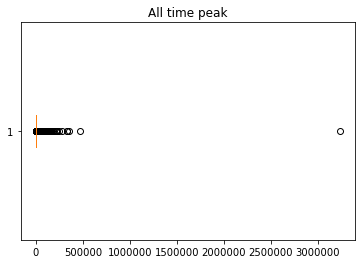

In [89]:
plt.boxplot(steam_df["all_time_peak"], vert=False)
plt.title("All time peak")
plt.show()

No other game comes anywhere near close, despite it being over 15 years since Steam released, so I feel very comfortable removing it from analyses. The chance of another game getting near that number of players is extremely low, so I don't think it will add much to the analysis

In [90]:
steam_df = steam_df[steam_df["all_time_peak"] < 3000000 ]
steam_df["all_time_peak"].max()

471955.0

Even with that gone, all the player count data looks rather exponentially distributed, which would siginificantly impact the accuracy of a linear regression:

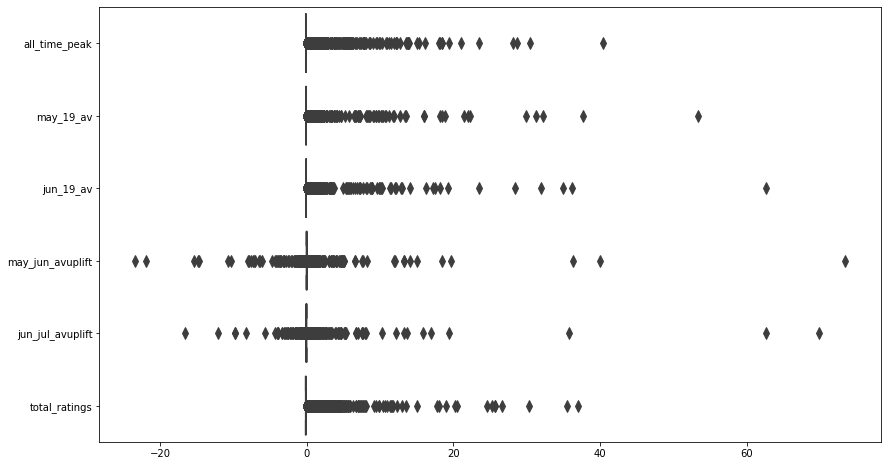

In [91]:
count_cols = ["all_time_peak", "may_19_av", "jun_19_av","may_jun_avuplift", "jun_jul_avuplift", "total_ratings"]

steam_counts = pd.DataFrame(StandardScaler().fit_transform(steam_df[count_cols])
                                                           ,columns=count_cols)

fig, ax = plt.subplots(figsize=(14,8))

sns.boxplot(data=steam_counts, orient='h',
            fliersize=8, linewidth=1.5, notch=True,
            saturation=0.5, ax=ax, whis=1.5)

plt.show()

In [92]:
steam_df.corr()[["jun_jul_avuplift"]].sort_values("jun_jul_avuplift", ascending=False).head(15)

,jun_jul_avuplift
jun_jul_avuplift,1.000000
jul_19_av,0.554758
jun_19_peak,0.460718
jun_19_av,0.410805
may_19_av,0.410227
total_ratings,0.363310
all_time_peak,0.298893
may_jun_avuplift,0.222834
may_19_peak,0.194178
price,0.095820


Log transforming makes our variables much more normally distributed (though still positively skewed).

In order to account for the negative numbers in the uplift, I convert them all to zero so the log transform work. Other transformers tried that can account for zeros (Power Transformer, Fisher Transformer) were less successful at reducing the skew, so I have decided this is an acceptable course. The main aim is now to predict any increase, and count all decreases as just "no increase".

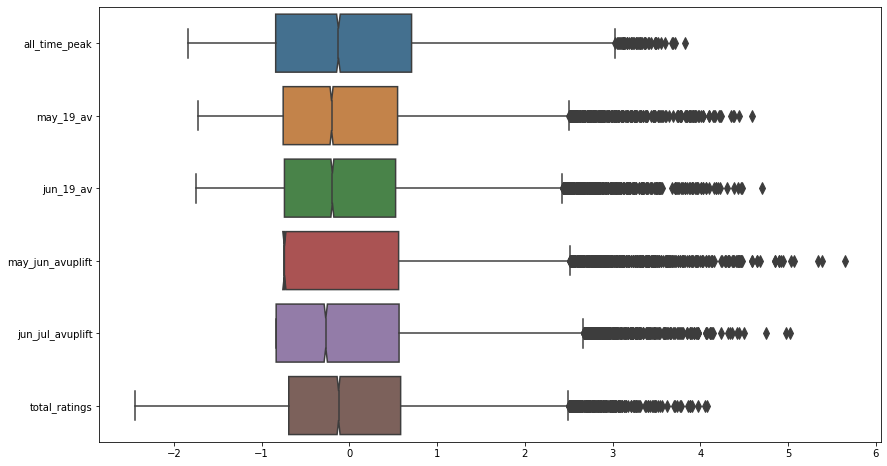

In [93]:
#log transforming and adding a constant to account for any zeros/negative numbers

steam_counts_log = pd.DataFrame()

for var in count_cols:
    steam_counts_log[var] = np.log(steam_df[var].map(lambda x: 0.01 if x<=0 else x+0.01))
                                            

steam_counts_log = pd.DataFrame(StandardScaler().fit_transform(steam_counts_log), columns= count_cols)

fig, ax = plt.subplots(figsize=(14,8))

sns.boxplot(data=steam_counts_log, orient='h',
            fliersize=8, linewidth=1.5, notch=True,
            saturation=0.5, ax=ax, whis=1.5)

plt.show()

In [94]:
steam_df_log=steam_df.copy()

for var in ["all_time_peak", "may_19_av", "jun_19_av", "jun_jul_avuplift", "may_jun_avuplift", "may_19_peak", "jun_19_peak", "total_ratings"]:
    steam_df_log[var] = np.log(steam_df_log[var].map(lambda x: 0.01 if x<=0 else x+0.01))
    
steam_df_log.corr()[["jun_jul_avuplift"]].sort_values("jun_jul_avuplift", ascending=False).head(15)

,jun_jul_avuplift
jun_jul_avuplift,1.000000
may_19_av,0.535975
jun_19_av,0.511644
may_19_peak,0.510707
jun_19_peak,0.509588
total_ratings,0.429606
all_time_peak,0.402729
price,0.331885
may_jun_avuplift,0.183698
jul_19_av,0.166493


C:\Users\James\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\James\Anaconda\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


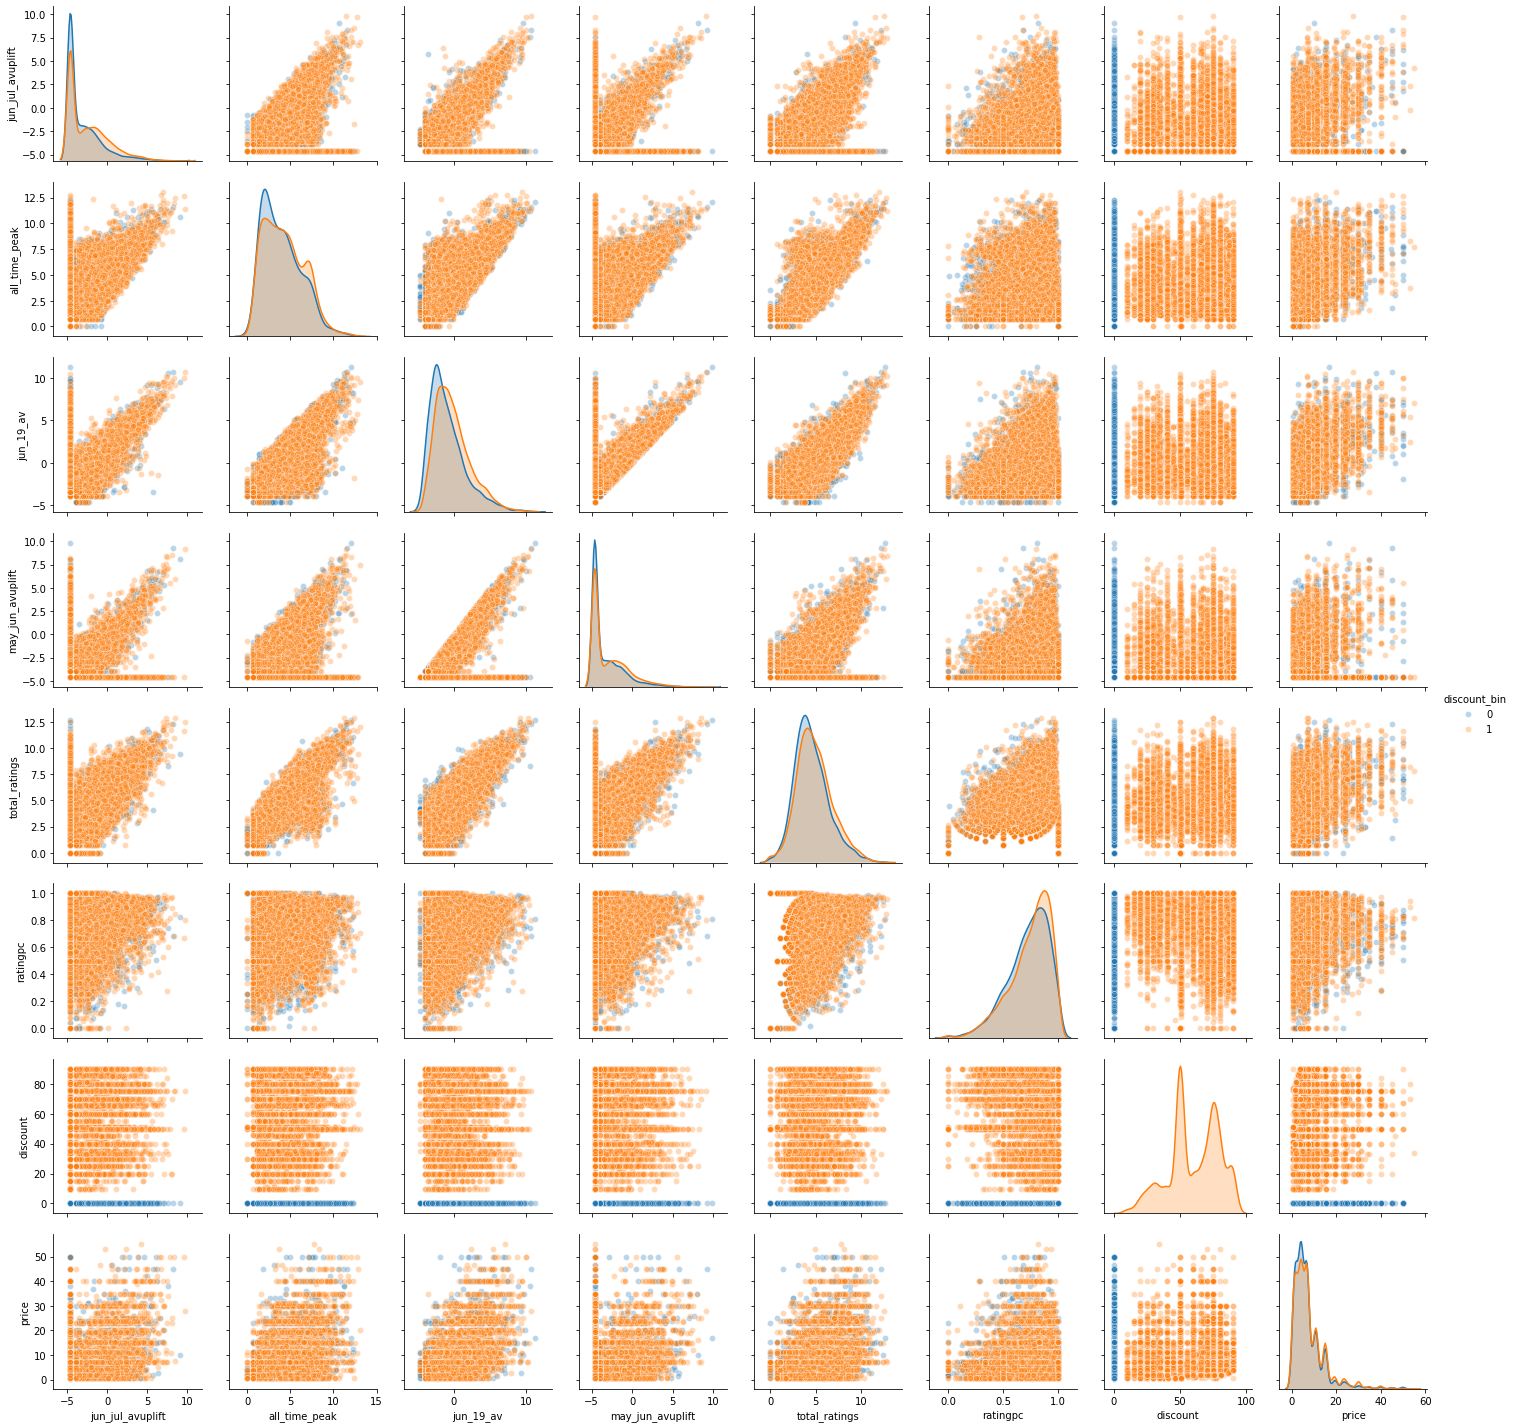

In [95]:
#Pairplot of some of the numeric variables. Hue is whether the game was on sale or not
sns.pairplot(steam_df_log, vars=["jun_jul_avuplift", "all_time_peak", "jun_19_av",
                                 "may_jun_avuplift","total_ratings", "ratingpc", 
                                 "discount", "price"], 
             hue="discount_bin", plot_kws={'alpha':0.3})
plt.show()

Based on the EDA, the distribution of my target variable will likely be one of the biggest challenges. Various ways I will try to account for it include:

    - transforming the target and other count variables. Most likely through a log transformation
        - as part of that transformation, all negative uplifts will be converted to zero
    - or I may try just converting the negatives to zeros and using a zero inflated model to account for the distributions
    - it may also be useful to do a binary classification of uplift vs. no uplift and then regress on the data that is predicted to have an uplift.
    
The decent correlations seen between my target and other variables leads me to believe there is a decent chance to create a fairly accurate model, but we'll see.

The fact that most of the strong correlations are just coming from other player count variables does make it feel like the result might just be "popular games get the biggest increase in players" which isn't exactly useful for a developer. As such I may take the linear regression of Current players vs. uplift as my baseline and then see how much, if at all, I can improve on that
   

In [96]:
steam_df.to_csv("../data/steam_munged_maydata_v2.csv", index=False)